In [1]:
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.datasets import load_sample_image
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from functools import partial

In [2]:
def plot_image(image):
    sns.heatmap(image, cmap = "gray", cbar = False)
    plt.axis("off")

def plot_clored(image):
    sns.heatmap(image, cbar = False)
    plt.axis("off")

In [3]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255

In [4]:
images = np.array([china, flower])


batch_size, height, width, channels = images.shape

In [5]:

images.shape

(2, 427, 640, 3)

Filters

In [6]:
filters = np.zeros(shape = (7, 7, channels, 2), dtype = np.float32)

filters[:, 3, :, 0] = 1 # Vertical line
filters[3, :, :, 1] = 1 # Horizontal line

Convolutional layer

In [7]:
outputs = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")

2024-02-25 17:21:59.366339: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-25 17:21:59.366367: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-25 17:21:59.366370: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-25 17:21:59.366399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-25 17:21:59.366415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Output shape

In [8]:
outputs.shape

TensorShape([2, 427, 640, 2])

Show first image's 2nd feature map.

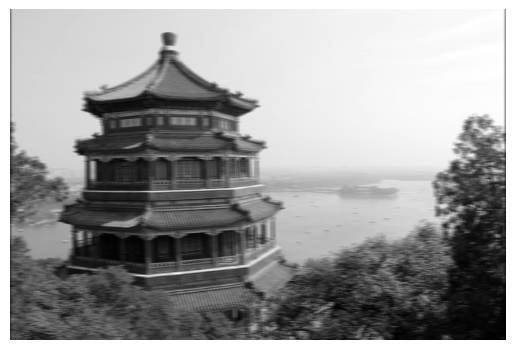

In [9]:
plt.imshow(outputs[0, :, :, 1], cmap = "gray")
plt.axis("off")
plt.show()

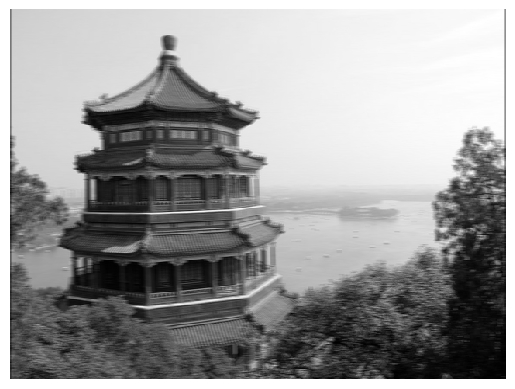

In [10]:
sns.heatmap(outputs[0, :, :, 1], cmap="gray", cbar=False)
plt.axis("off")
plt.show()


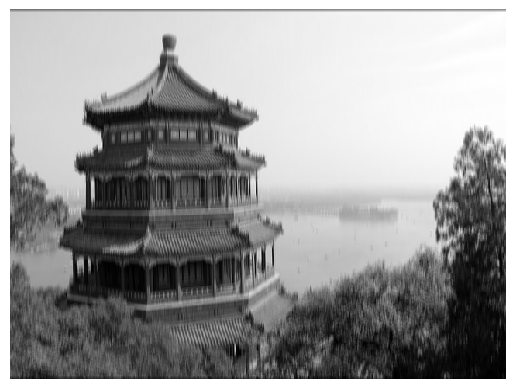

In [11]:
sns.heatmap(outputs[0, :, :, 0], cmap="gray", cbar=False)
plt.axis("off")
plt.show()


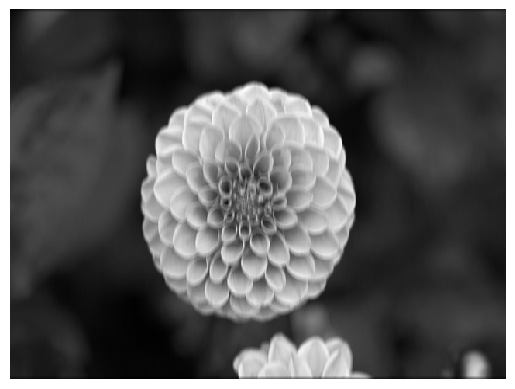

In [12]:
sns.heatmap(outputs[1, :, :, 0], cmap="gray", cbar=False)
plt.axis("off")
plt.show()


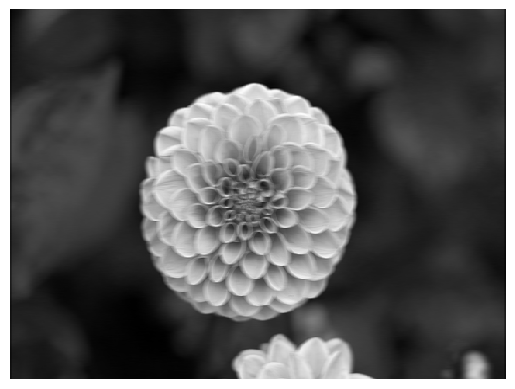

In [13]:
sns.heatmap(outputs[1, :, :, 1], cmap="gray", cbar=False)
plt.axis("off")
plt.show()


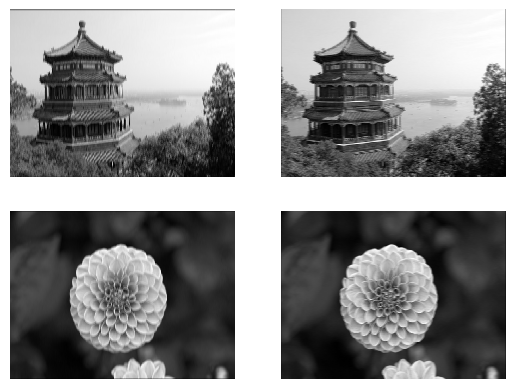

In [14]:
for image_i in (0, 1):
    for feature_map_i in (0, 1):
        plt.subplot(2, 2, image_i * 2 + feature_map_i + 1)
        plot_image(outputs[image_i, :, :, feature_map_i])

In [15]:
def crop_image (images):
    return images[150 : 230, 130 : 260]

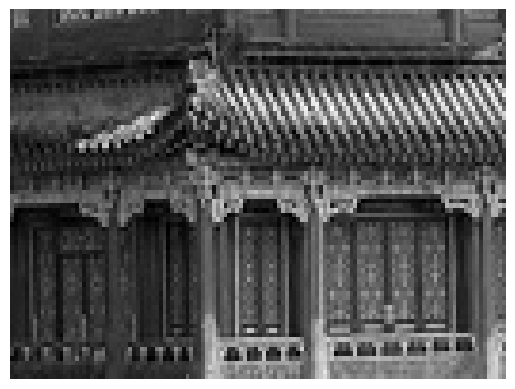

In [16]:
plot_image(crop_image(images[0, :, :, 0]))
plt.show()

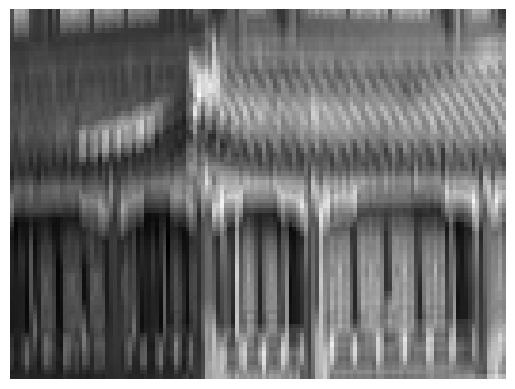

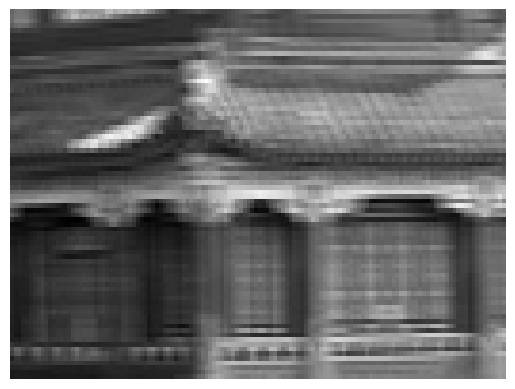

In [17]:
for  feature_map_i, orientation in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop_image(outputs[0, :, :, feature_map_i]))
    plt.show()

In [18]:
np.random.seed(100)
tf.random.set_seed(100)


conv = keras.layers.Conv2D(filters = 2, kernel_size = 7, strides = 1,
                           padding = "SAME",
                           activation = "relu",
                           input_shape = outputs.shape)

In [19]:
convolution_outputs = conv(images)

convolution_outputs.shape

TensorShape([2, 427, 640, 2])

Apply max_pool

In [20]:
outputs1 = tf.nn.max_pool(outputs, ksize = 3, strides = 1, padding = "SAME")

In [21]:
# sns.heatmap(outputs1[0, :, :, 0], cmap="gray", cbar=False)
# plt.axis("off")
plt.show()


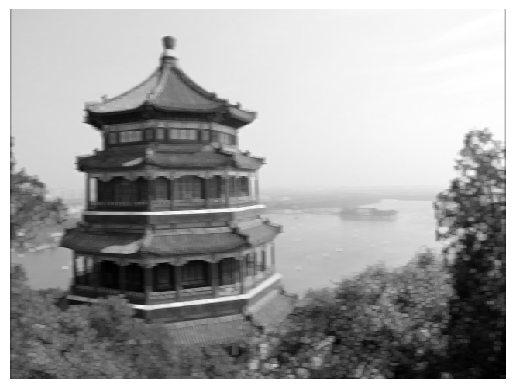

In [22]:
sns.heatmap(outputs1[0, :, :, 1], cmap="gray", cbar=False)
plt.axis("off")
plt.show()


Depth-wise pooling.

In [23]:
outputs2 = tf.nn.max_pool(outputs1,
                         ksize = (1, 1, 1, 2),
                         strides = (1, 1, 1, 2),
                         padding = "VALID")

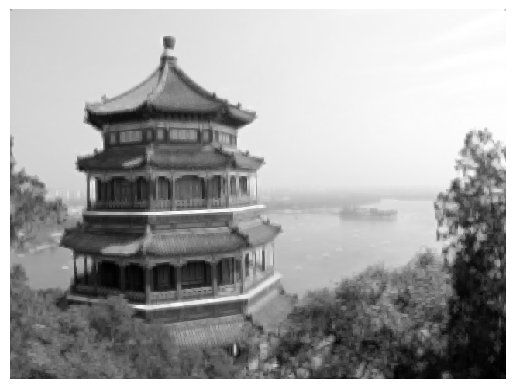

In [24]:
sns.heatmap(outputs2[0, :, :, 0], cmap="gray", cbar=False)
plt.axis("off")
plt.show()


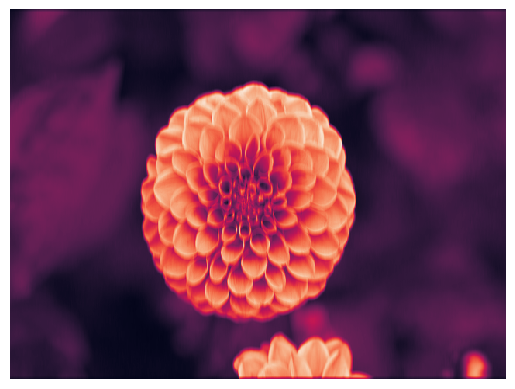

In [25]:
# sns.heatmap(outputs2[1, :, :, 0], cmap="gray", cbar=False)
# plt.axis("off")

plot_clored(outputs[1, :, :, 0])
plt.show()


Average Pooling.

In [26]:
outputs3 = tf.nn.avg_pool(outputs,
                          ksize = 2,
                          strides = 2,
                          padding = "VALID")

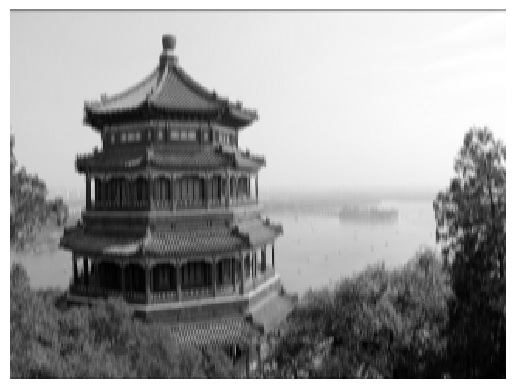

In [27]:
sns.heatmap(outputs3[0, :, :, 0], cmap="gray", cbar=False)
plt.axis("off")
plt.show()


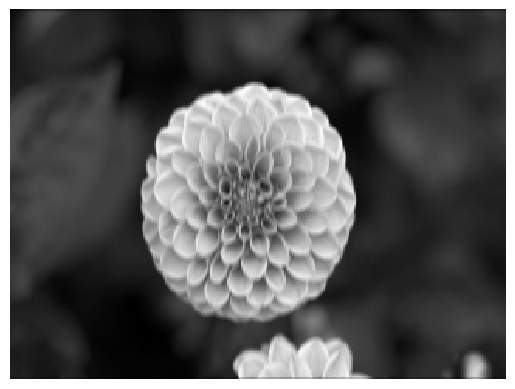

In [28]:
sns.heatmap(outputs3[1, :, :, 0], cmap="gray", cbar=False)
plt.axis("off")
plt.show()

CNN on MNIST Fashion.

In [29]:
fashion_mnist = keras.datasets.mnist

(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

In [30]:
x_train_full = x_train_full / 255.
x_test = x_test / 255.

x_train, x_valid = x_train_full[ : -5000], x_train_full[-5000 : ]
y_train, y_valid = y_train_full[ : -5000], y_train_full[-5000 : ]


x_train = x_train[..., np.newaxis]
x_valid = x_valid[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [31]:
keras.backend.clear_session()
np.random.seed(80)
tf.random.set_seed(80)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(256, 3, activation = "relu", padding = "same"),
    keras.layers.Conv2D(256, 3, activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D(2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = "softmax")
])

In [32]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [33]:
model.fit(x_train, y_train,
          epochs = 10,
          validation_data = (x_valid, y_valid))

Epoch 1/10


2024-02-25 17:22:03.718384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 32s 18ms/step - loss: 3568.0200 - accuracy: 0.7468 - val_loss: 1460.1947 - val_accuracy: 0.9584
Epoch 2/10
1719/1719 [==============================] - 32s 19ms/step - loss: 21177.9648 - accuracy: 0.9110 - val_loss: 13275.9023 - val_accuracy: 0.9690
Epoch 3/10
1719/1719 [==============================] - 31s 18ms/step - loss: 59188.4766 - accuracy: 0.9343 - val_loss: 28965.3789 - val_accuracy: 0.9782
Epoch 4/10
1719/1719 [==============================] - 32s 19ms/step - loss: 171683.0469 - accuracy: 0.9449 - val_loss: 152198.4688 - val_accuracy: 0.9708
Epoch 5/10
1719/1719 [==============================] - 31s 18ms/step - loss: 270856.9688 - accuracy: 0.9544 - val_loss: 181793.8125 - val_accuracy: 0.9786
Epoch 6/10
1719/1719 [==============================] - 31s 18ms/step - loss: 618999.3125 - accuracy: 0.9555 - val_loss: 183622.0938 - val_accuracy: 0.9846
Epoch 7/10
1719/1719 [==============================] - 31s 18ms/step - loss: 43716

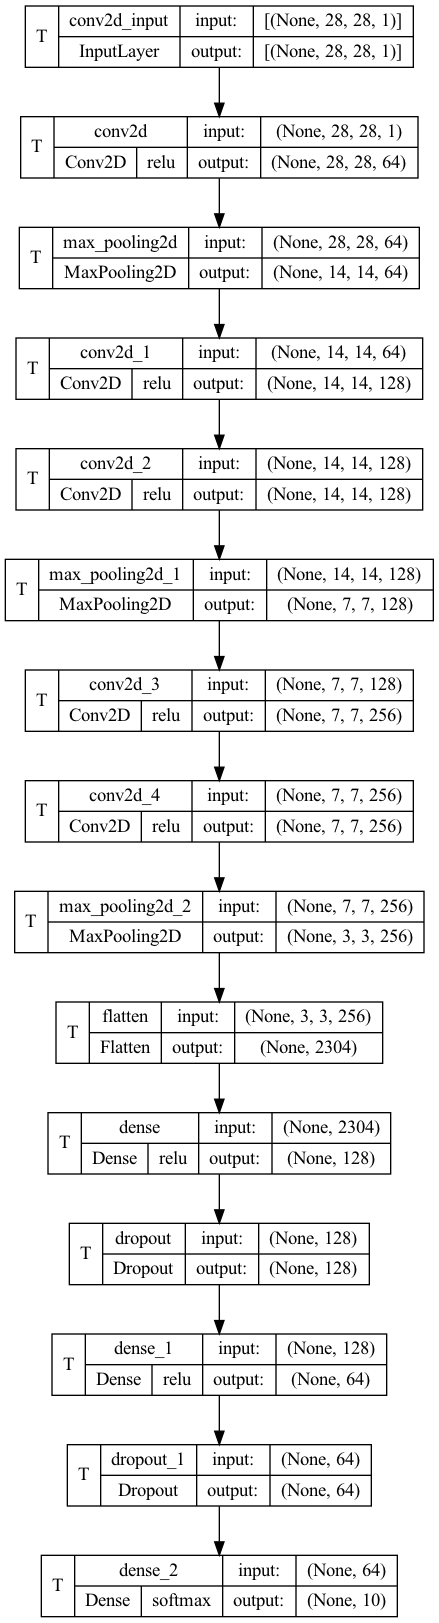

In [34]:
tf.keras.utils.plot_model(model,
                          to_file='model01.png', 
                          show_layer_names=True,
                          show_layer_activations = True,
                          show_trainable = True,
                          show_shapes = True,
                          dpi=96)

In [35]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 1339060.6250 - accuracy: 0.9845


[1339060.625, 0.984499990940094]

ResNet-34

In [36]:

class ResNet34:
    def __init__(self, input_shape=(224, 224, 3), num_classes=1000):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def identity_block(self, x, filters, kernel_size=3, strides=1):
        y = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)

        y = Conv2D(filters, kernel_size, padding='same')(y)
        y = BatchNormalization()(y)

        if strides != 1 or x.shape[-1] != filters:
            x = Conv2D(filters, 1, strides=strides, padding='same')(x)
        
        return Add()([x, y])

    def convolutional_block(self, x, filters, kernel_size=3, strides=1):
        y = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)

        y = Conv2D(filters, kernel_size, padding='same')(y)
        y = BatchNormalization()(y)

        shortcut = Conv2D(filters, 1, strides=strides, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)

        return Add()([shortcut, y])

    def build_model(self):
        input_layer = Input(shape=self.input_shape)

        x = Conv2D(64, 7, strides=2, padding='same')(input_layer)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(3, strides=2, padding='same')(x)

        x = self.convolutional_block(x, 64)
        for _ in range(2):
            x = self.identity_block(x, 64)

        x = self.convolutional_block(x, 128, strides=2)
        for _ in range(3):
            x = self.identity_block(x, 128)

        x = self.convolutional_block(x, 256, strides=2)
        for _ in range(5):
            x = self.identity_block(x, 256)

        x = self.convolutional_block(x, 512, strides=2)
        for _ in range(2):
            x = self.identity_block(x, 512)

        x = AveragePooling2D(pool_size=(7, 7))(x)
        x = Flatten()(x)

        output_layer = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs=input_layer, outputs=output_layer, name='resnet34')
        return model


In [37]:
# Create an instance of the ResNet34 class
resnet34_instance = ResNet34()

* Display the model summary

In [38]:

resnet34_instance.model.summary()

Model: "resnet34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d_5[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalization[0

In [39]:
model = resnet34_instance.model

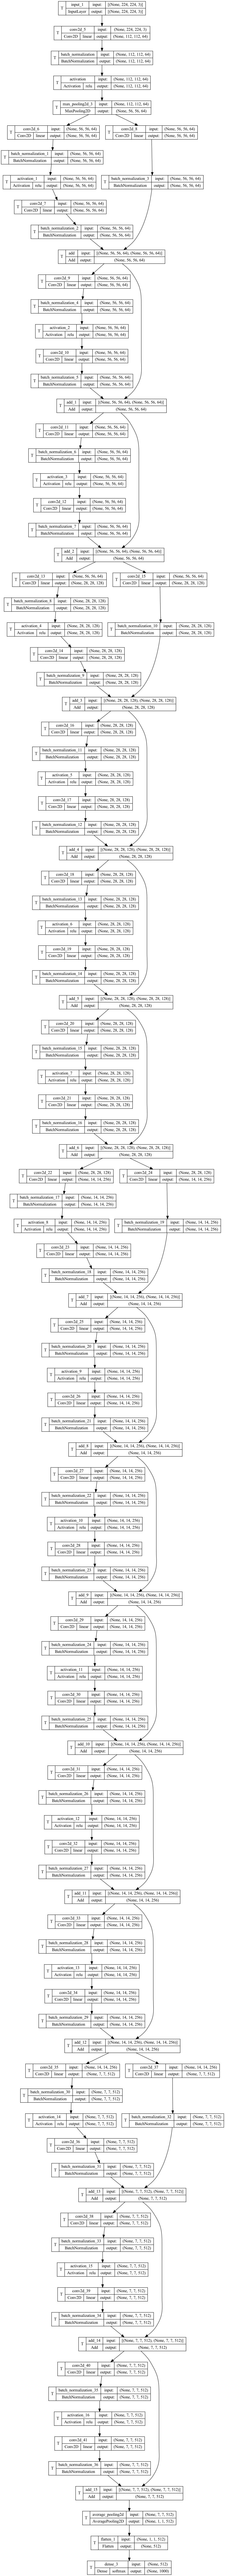

In [40]:
tf.keras.utils.plot_model(model,
                          to_file='model02.png', 
                          show_layer_names=True,
                          show_layer_activations = True,
                          show_trainable = True,
                          show_shapes = True,
                          dpi=96)

Using  a pre-trained Xception model for transfer learning.

In [41]:
(train_data, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split = ["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info = True,
    as_supervised =True
)


batch_size = 32

In [42]:
class_names = metadata.features["label"].names

In [43]:
num_class = metadata.features["label"].num_classes

In [44]:
image_size  = 224

def resize_and_rescale_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.resize(image, [image_size, image_size])
    image = (image / 255.0)
    return image, label

In [45]:
def augment_image (image_label, seed = 100):
    image, label = image_label
    image, label = resize_and_rescale_image(image, label)
    image = tf.image.resize_with_crop_or_pad(image, image_size + 6, image_size + 6)
    
    new_seed = tf.random.split(seed, num = 1)[0, :]
    #Random crop back to the Original size.
    image = tf.image.stateless_random_crop(
        image, size = [image_size, image_size, 3],
        seed = seed
    )

    #Random Brightness.
    image = tf.image.stateless_random_brightness(
        image, max_delta = 0.5,
        seed = new_seed
    )
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def preprocessed (image, label, randomized = True):
    if randomized:
        augmented = augment_image(image)
    final_image = keras.applications.xception.preprocess_input(augmented)
    return final_image, label


In [46]:
""" Create a `Counter` object and `Dataset.zip` it together with the training set. """

counter = tf.data.Dataset.range(len(train_data))
train_data = tf.data.Dataset.zip(train_data, (counter, counter))

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_data.shuffle(1000).repeat()
val_ds = val_ds.shuffle(1000).repeat()

In [48]:
train_set = (
    train_set
    .map(augment_image, num_parallel_calls = AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
    )

In [49]:
val_set = (
    val_ds
    .map(resize_and_rescale_image, num_parallel_calls = AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
    )

In [50]:
test_set = (
    test_ds
    .map(resize_and_rescale_image, num_parallel_calls = AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
    )

2024-02-25 17:27:26.068237: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


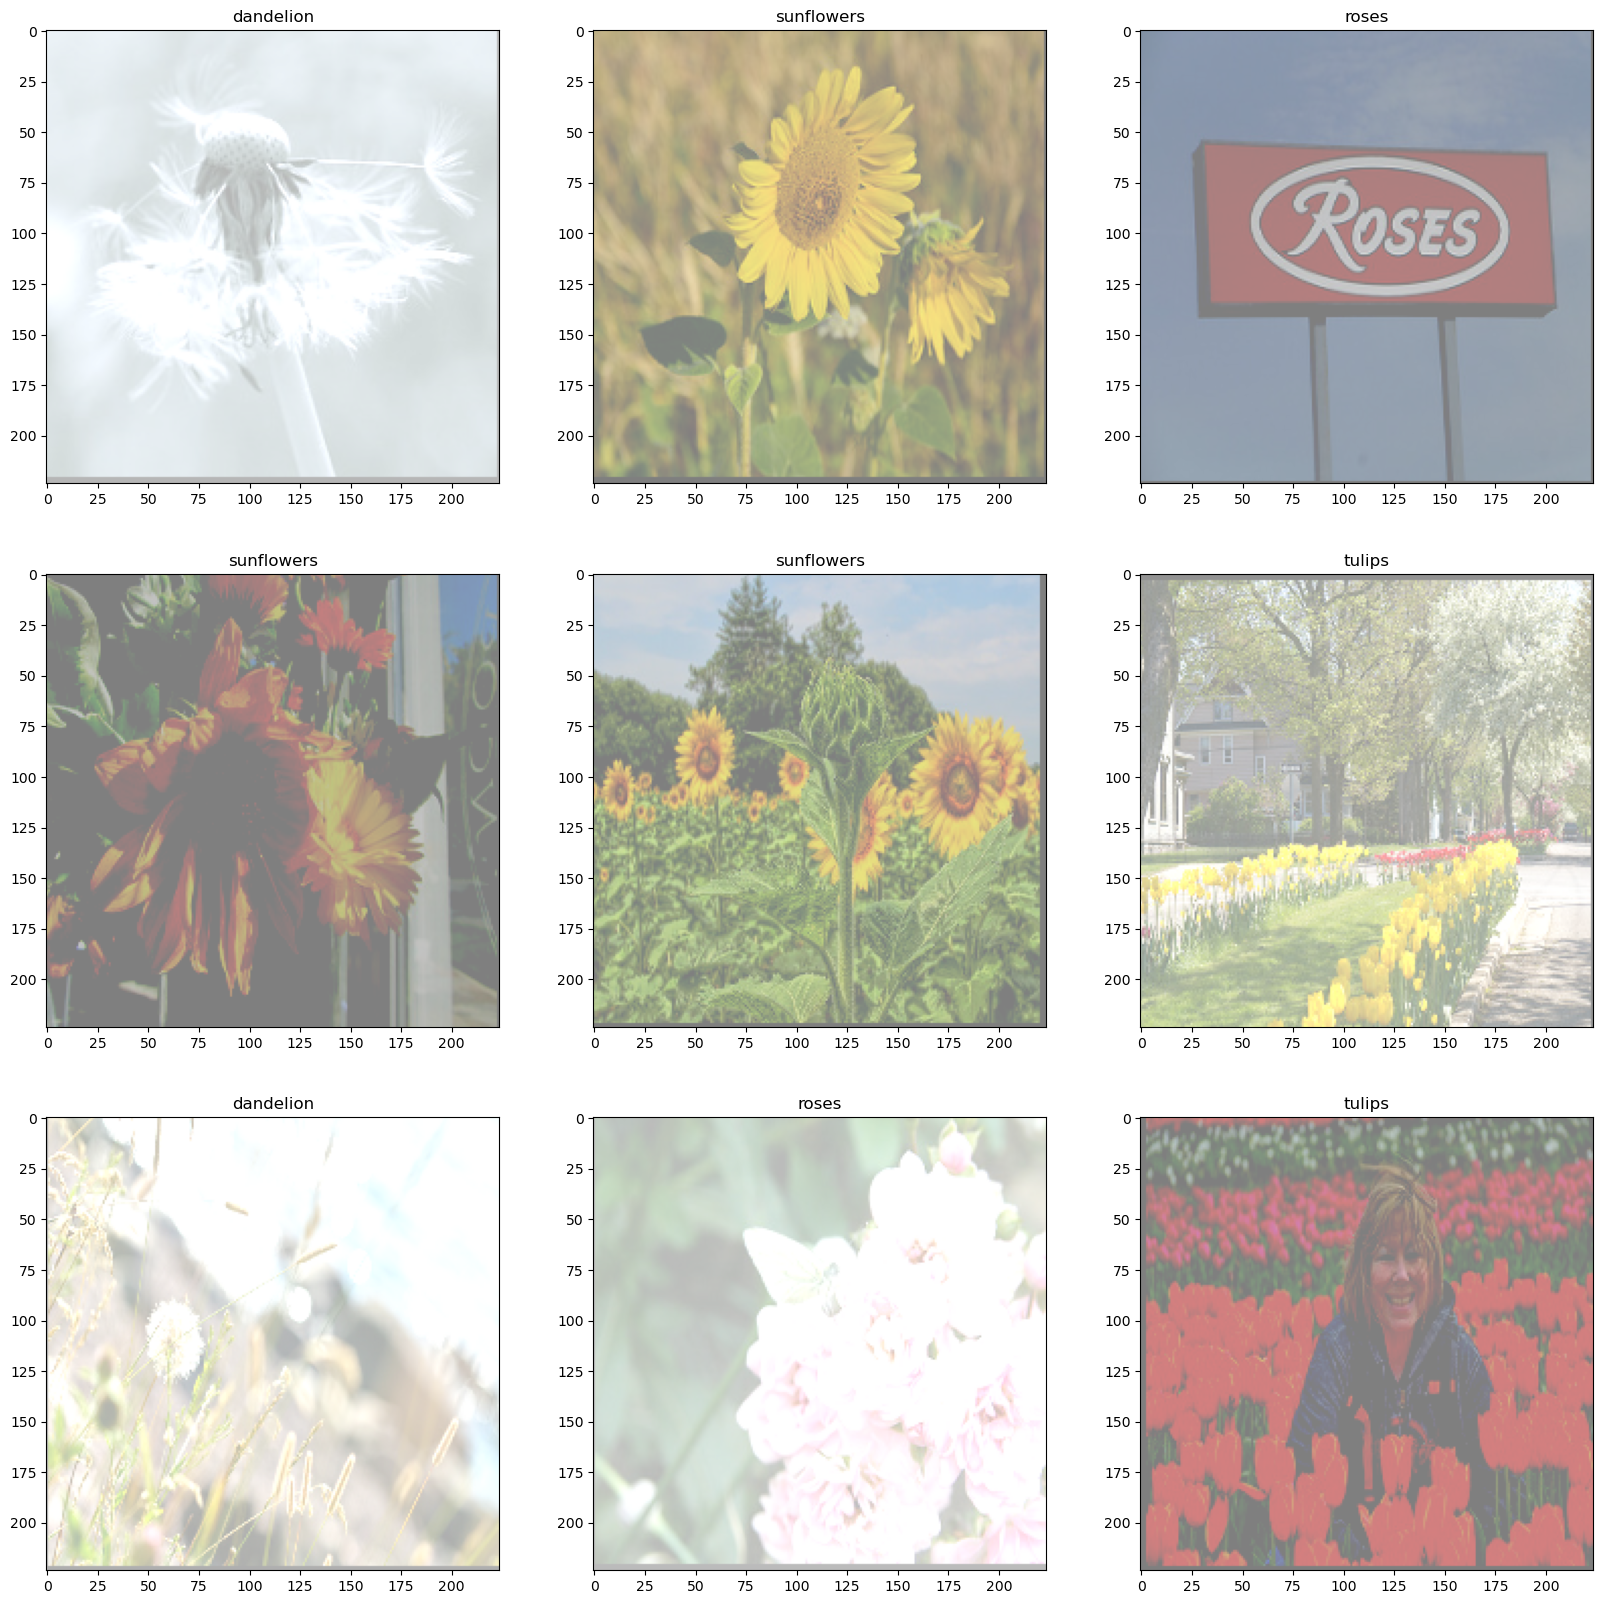

In [51]:
plt.figure(figsize = (20, 20))
for x_batch, y_batch in train_set.take(1):
    for i in range (9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i] /2 + 0.5)
        plt.title(f"{class_names[y_batch[i]]}")

Load the Xception model

In [52]:
model_base = keras.applications.xception.Xception(
    weights = "imagenet",
    include_top = False
)

In [53]:
average = keras.layers.GlobalAveragePooling2D()(model_base.output)
output = keras.layers.Dense(num_class, activation = "softmax")(average)

In [54]:
model = keras.models.Model(inputs = model_base.input, outputs = output)

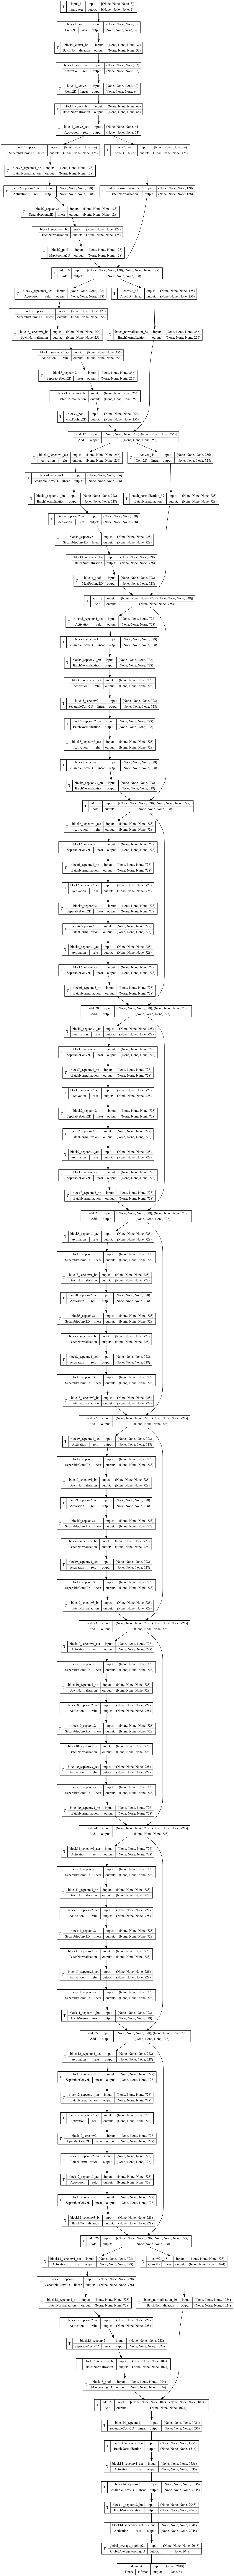

In [55]:
tf.keras.utils.plot_model(model,
                          to_file='model03.png', 
                          show_layer_names=True,
                          show_layer_activations = True,
                          show_trainable = True,
                          show_shapes = True,
                          dpi=96)

In [56]:
dataset_size = metadata.splits["train"].num_examples

In [57]:
for layer in model_base.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate = 0.2, momentum = 0.9, weight_decay = 0.01)
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = optimizer,
              metrics = ["accuracy"])

In [58]:
history = model.fit(
    train_set,
    steps_per_epoch = int(0.75 * dataset_size / batch_size),
    validation_data = val_set,
    validation_steps = int(0.15 * dataset_size / batch_size),
    epochs = 5
)

Epoch 1/5
86/86 [==============================] - 24s 257ms/step - loss: 1.6880 - accuracy: 0.7544 - val_loss: 1.3569 - val_accuracy: 0.8199
Epoch 2/5
86/86 [==============================] - 21s 245ms/step - loss: 0.9497 - accuracy: 0.8459 - val_loss: 0.6448 - val_accuracy: 0.8676
Epoch 3/5
86/86 [==============================] - 21s 244ms/step - loss: 0.8630 - accuracy: 0.8616 - val_loss: 1.1613 - val_accuracy: 0.8254
Epoch 4/5
86/86 [==============================] - 21s 244ms/step - loss: 0.6409 - accuracy: 0.8812 - val_loss: 1.0041 - val_accuracy: 0.8438
Epoch 5/5
86/86 [==============================] - 22s 257ms/step - loss: 0.5443 - accuracy: 0.9004 - val_loss: 1.8181 - val_accuracy: 0.7316


In [59]:
for layer in model_base.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate = 0.01,
                                 momentum = 0.9,
                                 weight_decay = 0.001, nesterov = True)


model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = optimizer,
              metrics = ["accuracy"])

In [60]:
history = model.fit(
    train_set,
    steps_per_epoch = int(0.75 * dataset_size / batch_size),
    validation_data = val_set,
    validation_steps = int(0.15 * dataset_size / batch_size),
    epochs = 40
)

Epoch 1/40
86/86 [==============================] - 104s 1s/step - loss: 0.5444 - accuracy: 0.8314 - val_loss: 1.0577 - val_accuracy: 0.8456
Epoch 2/40
86/86 [==============================] - 89s 1s/step - loss: 0.1302 - accuracy: 0.9553 - val_loss: 0.3275 - val_accuracy: 0.9173
Epoch 3/40
86/86 [==============================] - 86s 999ms/step - loss: 0.0644 - accuracy: 0.9786 - val_loss: 0.2500 - val_accuracy: 0.9265
Epoch 4/40
86/86 [==============================] - 87s 1s/step - loss: 0.0343 - accuracy: 0.9895 - val_loss: 0.3536 - val_accuracy: 0.9191
Epoch 5/40
86/86 [==============================] - 87s 1s/step - loss: 0.0171 - accuracy: 0.9953 - val_loss: 0.2937 - val_accuracy: 0.9467
Epoch 6/40
86/86 [==============================] - 85s 988ms/step - loss: 0.0123 - accuracy: 0.9949 - val_loss: 0.2988 - val_accuracy: 0.9246
Epoch 7/40
86/86 [==============================] - 88s 1s/step - loss: 0.0153 - accuracy: 0.9945 - val_loss: 0.2180 - val_accuracy: 0.9467
Epoch 8/40
86

In [61]:
results = model.evaluate(test_set)

12/12 [==============================] - 3s 284ms/step - loss: 0.2263 - accuracy: 0.9537


In [62]:
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

Test Loss: 0.22629104554653168
Test Accuracy: 0.9536784887313843
